## Comparison: FiMDP vs STORM

In [6]:
import fimdp
import fimdpenv
import fimdpenv.UUVEnv as UUVEnv
fimdpenv.setup()
import stormpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fimdp import io as fi2st
from fimdp.objectives import AS_REACH, BUCHI
from fimdp.energy_solvers import BasicES

## Introduction

This notebook investigates whether the approach used in FiMDP can help it beat the efficiency of Storm, open-source, state-of-the-art probablistic model checker designed to be efficient in terms of time and memory. We use the UUV environment provided as a part of FiMDPEnv for performing the experiments required to compare the tools. 
We measure the time FiMDP needs to analyze a given consumption MDP (ConsMDP) and to synthesize the corresponding strategy for the given Büchi objective. We also transform the ConsMDP into the equivalent MDP with the energy constraints encoded in states and actions. We then measure the time that Stormpy needs to finish stormpy.model checking(mdp, prop) for this MDP and the qualitative Büchi property expressed in PCTL [1] as: prop = ’Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]’. 


The following are a set of functions that help calculate the average computation time for a variety of increasingly expensive tasks using both FiMDP and Storm. The function creates a grid-world with a specified size and capacity and pre-specified location of reload states and target states and uses the same environment to calculate the solution using both the tools. Proceed to the next section to compute and view the results.

In [9]:
def buchi_storm(storm_mdp):
    formula = 'Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]'
    prop = stormpy.parse_properties(formula)
    
    return stormpy.model_checking(storm_mdp, prop[0])

In [10]:
def buchi_fimdp(mdp, capacity, targets):
    solver = BasicES(mdp, capacity, targets)
    fimdp_res = solver.compute(BUCHI)

In [11]:
def create_gw(size, capacity):

    constants = {
        "size_x" : size,
        "size_y" : size,
        "capacity" : capacity,
        "cons_w_ex" : 0,
        "cons_s_ex" : 0,
        "targets" : [13,2],
        "reloads" : [15,3],
    }

    env = UUVEnv.SingleAgentEnv([constants["size_x"], constants["size_y"]], constants["capacity"], constants["targets"], constants["reloads"])
    return env.consmdp, set(constants["targets"])

In [12]:
def benchmark_on_gw(size_range, cap_range):
    df = pd.DataFrame(columns=["size", "capacity", "cmdp_size", "mdp_size", "fimdp_time", "storm_time"])

    for size in size_range:
        for capacity in cap_range:
            cap = int(capacity*size)
            print(f"size={size} and capacity={cap}")
            res = {
                "size": size,
                "capacity": cap,
            }

            mdp, targets = create_gw(size, cap)
            res["cmdp_size"] = mdp.num_states

            st_mdp = fi2st.encode_to_stormpy(mdp, cap, targets)
            res["mdp_size"] = st_mdp.nr_states

            fimdp_time = %timeit -o -q buchi_fimdp(mdp, cap, targets)
            res["fimdp_time"] = fimdp_time.average
            storm_time = %timeit -o -q buchi_storm(st_mdp)
            res["storm_time"] = storm_time.average

            df = df.append(res, ignore_index=True)
    return df

### Performing Calculations

We use the benchmark_on_gw() function defined above to calculate the computation time for a different environments. The function takes two inputs: (i) a list of grid sizes, and (ii) a list of capacity scaling factors, and performs experiments with each grid size for capacities equal to each given factor multiplied with the grid size. This way, the capacity of the agents in any test environment will be proportional to the grid-size of the environment. The following script calls the function for grid sizes 10, 20, and 50 for a capacity factors of 1, 2, 3, 5, and 10 and stores the data in the current working directory. 

In [ ]:
# generate results for various grid sizes and energies
results = {}
results["gs10"] = benchmark_on_gw([10], [1,2,3,5,10])
results["gs20"] = benchmark_on_gw([20], [1,2,3,5,10])
results["gs50"] = benchmark_on_gw([50], [1,2,3,5,10])

In [12]:
# store the data as csv files
for k, v in results.items():
    v.to_csv('./data/{}_timedata.csv'.format(k))

The next section loads stored data from our computations and visualizes them for a comparison of the tools. Note that these are the same results presented in the 'Evaluation' section of the paper.

### Computation Time Comparison

The following plots compare the average computation time for finding a solution to different problems using both FiMDP and Storm. All computations presented below were performed on a PC with Intel Core i7-8700 3.20GHz 12 core processor and a RAM of 16 GB running Ubuntu 18.04 LTS. We start with defining some functions to help us perform the comparison. 

In [13]:
# load the data
df_gs10 = pd.read_csv('./data/gs10_timedata.csv')
df_gs20 = pd.read_csv('./data/gs20_timedata.csv')
df_gs50 = pd.read_csv('./data/gs50_timedata.csv')
data = pd.concat([df_gs10, df_gs20, df_gs50])
data

,size,capacity,cmdp_size,mdp_size,fimdp_time,storm_time
0,10,10,100,1071,0.008771,0.002810
1,10,20,100,2041,0.008932,0.007125
2,10,30,100,3011,0.008389,0.010739
3,10,50,100,4951,0.008557,0.018387
4,10,100,100,9801,0.008513,0.038135
0,20,20,400,8341,0.063166,0.021742
1,20,40,400,16281,0.126039,0.080295
2,20,60,400,24221,0.124745,0.136247
3,20,100,400,40101,0.123667,0.259122
4,20,200,400,79801,0.125203,0.571519


In [14]:
# function to plot the data for different grid sizes
def plot_comptime(dataframe, grid_size):
    df = dataframe.melt(id_vars=['capacity'], value_vars=['fimdp_time', 'storm_time'])
    sns.scatterplot(x='capacity', y='value', hue='variable', data=df)
    plt.ylabel('time (sec)')
    plt.title('Grid Size {}'.format(grid_size))
    plt.show()

### Grid Size 10 

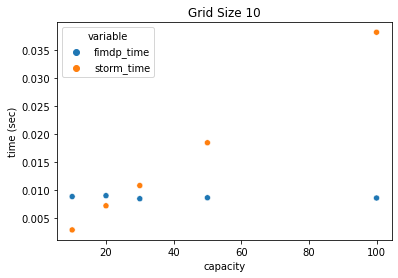

In [15]:
plot_comptime(df_gs10, 10)

### Grid Size 20

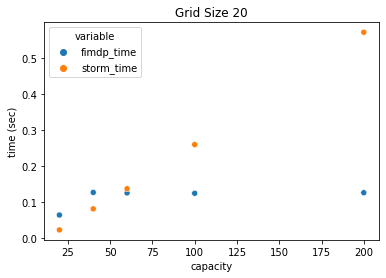

In [16]:
plot_comptime(df_gs20, 20)

### Grid Size 50

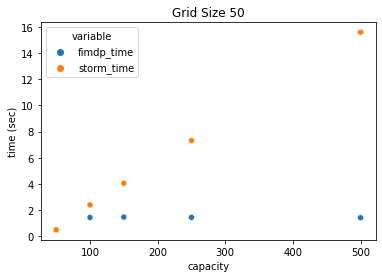

In [17]:
plot_comptime(df_gs50, 50)